In [2]:
! pip install ./python_files
from python_files import *
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available, training on: ", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

Processing c:\users\tbird\documents\github\06-665-psm-final-project\python_files
  Created wheel for python-files: filename=python_files-0.1.0-py3-none-any.whl size=1023 sha256=21e61d1d44d9ec55dc8df219e96426c9f5fad2773fc6da74e5519f88bacc7ba5
  Stored in directory: C:\Users\tbird\AppData\Local\Temp\pip-ephem-wheel-cache-nlmmn5a6\wheels\ca\c1\3d\7f33f532b3f9eddd59bbd2ddd1f7583d50a6829274a8d07efa
Successfully built python-files
  Attempting uninstall: python-files
    Found existing installation: python-files 0.1.0
    Uninstalling python-files-0.1.0:
      Successfully uninstalled python-files-0.1.0


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


GPU is available, training on:  NVIDIA GeForce RTX 2070 Super with Max-Q Design


# NN Training and Testing

### Getting data for the NN training and testing

In [3]:
# loading data from saved folder
solutions = np.load("./saved/100_solutions.npy")
F_ag_array = np.load("./saved/100_F_ag.npy")
test_solutions = np.load("./saved/10test_solutions.npy")
test_F_ag_array = np.load("./saved/10test_F_ag.npy")
num_timesteps = 500
# Concatenating training data before preprocessing
solutions_w_F_ag = np.concatenate((solutions, F_ag_array.reshape(100,1,num_timesteps)), axis=1)
# Preprocessing training data
train_data = data_preprocessing(solutions_w_F_ag, N = 100, num_timesteps = num_timesteps, batch_size = 1, shuffle = False)
print("Training data preprocessing done")
# Concatenating test data before preprocessing
test_solutions_w_F_ag = np.concatenate((test_solutions, test_F_ag_array.reshape(10,1,num_timesteps)), axis=1)
# Preprocessing test data
test_data = data_preprocessing(test_solutions_w_F_ag, N = 10, num_timesteps = num_timesteps, batch_size = 1, shuffle = False)
print("Test data preprocessing done")

pre-processing data with N = 100
Training data preprocessing done
pre-processing data with N = 10
Test data preprocessing done


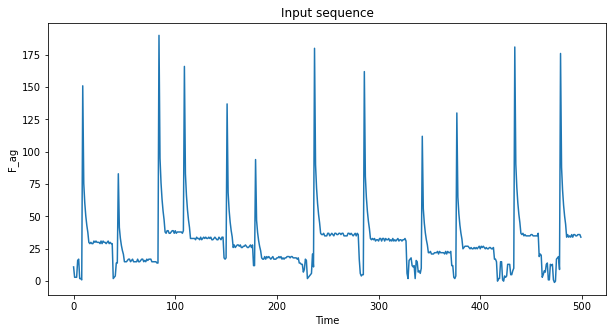

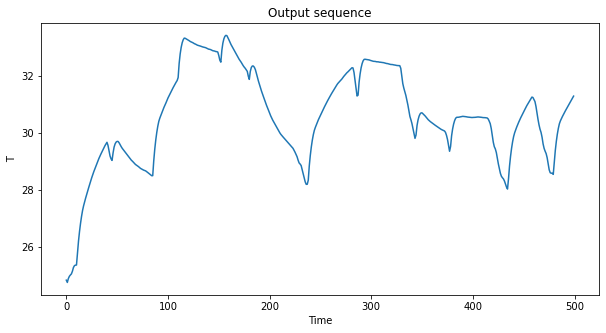

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(F_ag_array[0,:])
plt.title("Input sequence")
plt.xlabel("Time")
plt.ylabel("F_ag")
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(solutions[0, 4, :]-273.15)
plt.title("Output sequence")
plt.xlabel("Time")
plt.ylabel("T")
plt.show()

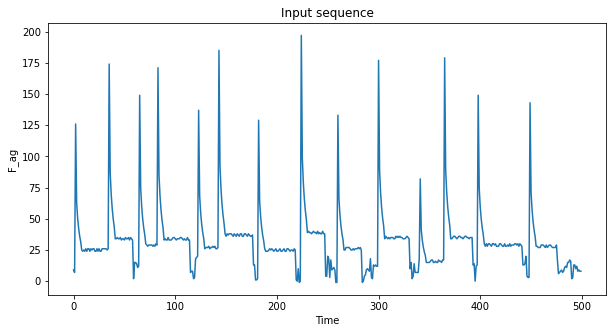

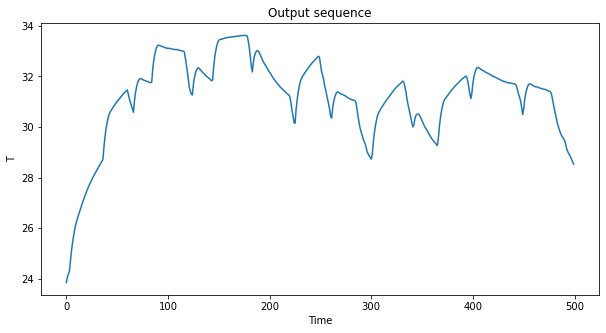

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(test_F_ag_array[0,:])
plt.title("Input sequence")
plt.xlabel("Time")
plt.ylabel("F_ag")
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(test_solutions[0, 4, :]-273.15)
plt.title("Output sequence")
plt.xlabel("Time")
plt.ylabel("T")
plt.show()

### The following block only needs to be used if new data is needed

In [3]:

# N = 100
# solutions_name = str(N) + "_solutions.npy"
# F_ag_array_name = str(N) + "_F_ag.npy"
# save_dir = "./saved"
# os.makedirs (save_dir, exist_ok=True)

# num_timesteps = 500
# train_random_inputs = generate_inputs (N)
# solutions, F_ag_array = generate_ode_data(train_random_inputs, num_timesteps)

# print ("="*50)
# print ("Saved: ")
# print (f"{solutions_name}: {solutions.shape}")
# print (f"{F_ag_array_name}: {F_ag_array.shape}")
# print ("="*50)

# # SAVE
# np.save (join(save_dir, solutions_name), solutions)
# np.save (join(save_dir, F_ag_array_name), F_ag_array)

# # PLOT
# plot_ode_solutions (solutions)
# plot_input_output(F_ag_array, solutions, N)


### The following block only needs to be used if new data is needed

In [8]:
# N = 10
# test_solutions_name = str(N) + "test_solutions.npy"
# test_F_ag_array_name = str(N) + "test_F_ag.npy"
# save_dir = "./saved"
# os.makedirs (save_dir, exist_ok=True)


# test_random_inputs = generate_inputs (N)
# test_solutions, test_F_ag_array = generate_ode_data(test_random_inputs, num_timesteps=500)

# print ("="*50)
# print ("Saved: ")
# print (f"{test_solutions_name}: {test_solutions.shape}")
# print (f"{test_F_ag_array_name}: {test_F_ag_array.shape}")
# print ("="*50)

# # SAVE
# np.save (join(save_dir, test_solutions_name), test_solutions)
# np.save (join(save_dir, test_F_ag_array_name), test_F_ag_array)

# # PLOT
# plot_ode_solutions (test_solutions)
# plot_input_output(test_F_ag_array, test_solutions, N)

### Training and test the NN (2 hidden layers, 64 neurons, 20 epochs)

In [13]:
import time
import torch.nn as nn
# NOTE: modified train_and_test
def train_and_test(model, train_loader, test_loader, optimizer = "Adam", num_epochs = 1):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam (model.parameters(), lr=0.01)
    
    epoch_train_loss_list_mean_per_simulation = []
    overall_train_loss_list_one_value_per_epoch = []
    overall_test_loss_list_one_value_per_epoch = []
    full_train_loss = [] # added
    j = 0
    start_time = time.time()  
    for e in range (num_epochs):
        epoch = e + 1
        model.train()
        
        for n, data in enumerate (train_loader):
            # print("n:", n, "data shape:", data.shape, "data.shape[1]:", data.shape[1])
            train_loss_list_per_simulation = []
            for i in range(data.shape[1]-1):
                # print("i:", i)

                prev_4_states = data[0, i, :-1].float().flatten().to(device)
                # print("prev_4_states size", prev_4_states.size())

                current_temp = data[0, i, -1].float().flatten().to(device)
                # print("current_state size", current_temp.size())
                
                predicted_current_temp = model(prev_4_states) # (1,)
                loss = loss_func (current_temp, predicted_current_temp)
                train_loss_list_per_simulation.append (loss.item())
                full_train_loss.append (loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                j+=1
                # if j % 1000 == 0:
                    # print(f"Global iterations {j} | loss = {loss}")
            epoch_train_loss_list_mean_per_simulation.append(np.mean(train_loss_list_per_simulation))
            
        if epoch % 1 == 0:
            print(f"Epoch {epoch} | Epoch mean training loss for a single simulation = {np.mean(epoch_train_loss_list_mean_per_simulation)}")
        overall_train_loss_list_one_value_per_epoch.append(np.mean(epoch_train_loss_list_mean_per_simulation))
        epoch_test_loss_list_mean_per_simulation = []
        
        model = model.eval()
        
        test_loss = 0
        with torch.no_grad():
            for n, data in enumerate (test_loader):
                # print("n:", n, "data shape:", data.shape, "data.shape[1]:", data.shape[1])
                model_output = []
                ground_truth = []
                test_loss_list_per_simulation = []
                for i in range(data.shape[1]-1):
                    # print("i:", i)

                    prev_4_states = data[0, i, :-1].float().flatten().to(device)
                    # print("prev_4_states size", prev_4_states.size())

                    current_temp = data[0, i, -1].float().flatten().to(device)
                    # print("current_state size", current_temp.size())
                    
                    predicted_current_temp = model(prev_4_states) # (1,)

                    model_output.append (predicted_current_temp.item()-273.15)
                    ground_truth.append (current_temp[0].item()-273.15)
                    # print("predicted_current_temp:", predicted_current_temp.item(), "ground_truth:", current_temp[0].item())
                    
                    loss = loss_func (current_temp, predicted_current_temp)
                    test_loss_list_per_simulation.append(loss.item())                
                
                
                # Checking for best model output
                if i == 0:
                    best_this_epoch_model_output = model_output
                    best_this_epoch_ground_truth = ground_truth
                    best_this_epoch_simulation_accuracy = np.mean(test_loss_list_per_simulation)

                    worst_this_epoch_model_output = model_output
                    worst_this_epoch_ground_truth = ground_truth
                    worst_this_epoch_simulation_accuracy = np.mean(test_loss_list_per_simulation)

                if i != 0: 
                    if np.mean(test_loss_list_per_simulation) < min(epoch_test_loss_list_mean_per_simulation):
                        best_this_epoch_model_output = model_output
                        best_this_epoch_ground_truth = ground_truth
                        best_this_epoch_simulation_accuracy = np.mean(test_loss_list_per_simulation)
                    # Checking for worst model output 
                    if np.mean(test_loss_list_per_simulation) < max(epoch_test_loss_list_mean_per_simulation):
                        worst_this_epoch_model_output = model_output
                        worst_this_epoch_ground_truth = ground_truth
                        worst_this_epoch_simulation_accuracy = np.mean(test_loss_list_per_simulation)
                epoch_test_loss_list_mean_per_simulation.append(np.mean(test_loss_list_per_simulation))

        print(f"Epoch {epoch} | Epoch mean test loss for a single simulation = {np.mean(epoch_test_loss_list_mean_per_simulation)}")
        if epoch == 1:
            best_epoch = epoch
            best_epoch_test_loss = np.mean(epoch_test_loss_list_mean_per_simulation)
            best_model_output = best_this_epoch_model_output
            best_ground_truth = best_this_epoch_ground_truth
            best_simulation_accuracy = best_this_epoch_simulation_accuracy
            worst_model_output = worst_this_epoch_model_output
            worst_ground_truth = worst_this_epoch_ground_truth
            worst_simulation_accuracy = worst_this_epoch_simulation_accuracy
        
        if epoch != 1:
            if np.mean(epoch_test_loss_list_mean_per_simulation) < min(overall_test_loss_list_one_value_per_epoch):
                best_epoch = epoch
                best_epoch_test_loss = np.mean(epoch_test_loss_list_mean_per_simulation)
                best_model_output = best_this_epoch_model_output
                best_ground_truth = best_this_epoch_ground_truth
                best_simulation_accuracy = best_this_epoch_simulation_accuracy
                worst_model_output = worst_this_epoch_model_output
                worst_ground_truth = worst_this_epoch_ground_truth
                worst_simulation_accuracy = worst_this_epoch_simulation_accuracy
        overall_test_loss_list_one_value_per_epoch.append(np.mean(epoch_test_loss_list_mean_per_simulation))
    print("The model's best epoch was", best_epoch, "with a test loss of", best_epoch_test_loss)
    print("The model's best simulation accuracy in that epoch was", best_simulation_accuracy)
    print("The model's worst simulation accuracy in that epoch was", worst_simulation_accuracy)
    # Generate best plot sample for each model
    pred_error = []
    for i in range(len(best_model_output)):
        pred_error.append(best_ground_truth[i] - best_model_output[i])
    plt.plot(pred_error)
    plt.title(f"Prediction error (ground truth - prediction) for set n = {epoch}")
    plt.xlabel("Timesteps")
    plt.ylabel("Error")
    plt.show();

    # Plot model output and ground truth
    plt.plot(best_ground_truth, label = "Ground Truth")
    plt.plot(best_model_output, label = "Model Output")
    plt.title(f"Model Output vs Ground Truth for set n = {epoch}")
    plt.xlabel("Timesteps")
    plt.ylabel("Temperature (C)")
    plt.legend()
    plt.show();
    # Generate worst plot sample for each model
    pred_error = []
    for i in range(len(worst_model_output)):
        pred_error.append(worst_ground_truth[i] - worst_model_output[i])
    plt.plot(pred_error)
    plt.title(f"Prediction error (ground truth - prediction) for set n = {epoch}")
    plt.xlabel("Timesteps")
    plt.ylabel("Error")
    plt.show();

    # Plot model output and ground truth
    plt.plot(worst_ground_truth, label = "Ground Truth")
    plt.plot(worst_model_output, label = "Model Output")
    plt.title(f"Model Output vs Ground Truth for set n = {epoch}")
    plt.xlabel("Timesteps")
    plt.ylabel("Temperature (C)")
    plt.legend()
    plt.show();
      
        
    # Plot loss
    plt.plot(overall_train_loss_list_one_value_per_epoch, label = "Train Loss")
    plt.plot(overall_test_loss_list_one_value_per_epoch, label = "Test Loss")
    plt.legend()
    plt.title("Loss Plot")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show();
    # Evaluating time taken
    end_time = time.time() 
    elapsed_time = end_time - start_time          
    print("Time per epoch = ", elapsed_time/num_epochs)
    print("Total time = ", elapsed_time, "sec")

    return overall_test_loss_list_one_value_per_epoch, full_train_loss, elapsed_time, best_epoch_test_loss, best_simulation_accuracy, worst_simulation_accuracy

In [14]:
# # Initialize the NN
model = NeuralNet(num_hidden_layers = 2, input_size = 8, hidden_size = 3, output_size = 1, dropout_rate = 0.0)#, device = device)
# # Train the NN
overall_test_loss_list_one_value_per_epoch, full_train_loss, elapsed_time, best_epoch_test_loss, best_simulation_accuracy, worst_simulation_accuracy = train_and_test(model, train_data, test_data, optimizer = "Adam", num_epochs = 2)